In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


In [2]:
import os
PATH="/content/gdrive/My Drive/Image Quality/datasets/"
#PATH=os.getcwd()
(os.listdir(PATH))

['train', 'val']

In [5]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

In [6]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [13]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
import random as rn
import datetime

In [9]:
datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True)

In [11]:
train_generator = datagen.flow_from_directory(
                                            directory="/content/gdrive/My Drive/Image Quality/datasets/train",
                                        
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(256,256))

valid_generator = datagen.flow_from_directory( 
                                            directory="/content/gdrive/My Drive/Image Quality/datasets/val",
                                           
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(256,256))
                                            

Found 7995 images belonging to 2 classes.
Found 2967 images belonging to 2 classes.


In [15]:

from tensorflow.keras.applications import EfficientNetB0
#model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
model = EfficientNetB0(weights='imagenet', include_top=False,input_shape=(256, 256, 3))

In [16]:
#don't train existing weights
for layer in model.layers:
 layer.trainable = False

In [17]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 256, 256, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_3[0][0]            
_____________________________________________________________________________________

In [19]:
#Conv Layer
Conv1 = Conv2D(filters=64,kernel_size=(8,8),strides=(1,1),padding='valid',activation='relu',name='Conv1')(model.layers[-1].output)

#Conv Layer
Conv2 = Conv2D(filters=32,kernel_size=(1,1),strides=(1,1),padding='valid',activation='relu',name='Conv2')(Conv1)

#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(Conv2)

#output layer
output = Dense(units=1,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(flatten)

In [20]:
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 256, 256, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_3[0][0]            
______________________________________________________________________________________________

In [21]:
import datetime
log_dir="/content/log1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)


In [32]:
#compiling 
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

lr_reducer = ReduceLROnPlateau(factor= 0.1,
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath='model1.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_reducer,tensorboard_callback]

In [34]:
##fitting generator
history = model.fit_generator(train_generator,epochs=5,validation_data = valid_generator,callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


250/250 [==============================] - 1329s 5s/step - loss: 0.0000e+00 - accuracy: 0.2805 - val_loss: 0.0000e+00 - val_accuracy: 0.4944

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model1.h5


In [35]:
history.history

{'accuracy': [0.2774233818054199],
 'loss': [0.0],
 'lr': [0.8],
 'val_accuracy': [0.4944388270378113],
 'val_loss': [0.0]}

Text(0.5, 1.0, 'Training and Validation Accuracy')

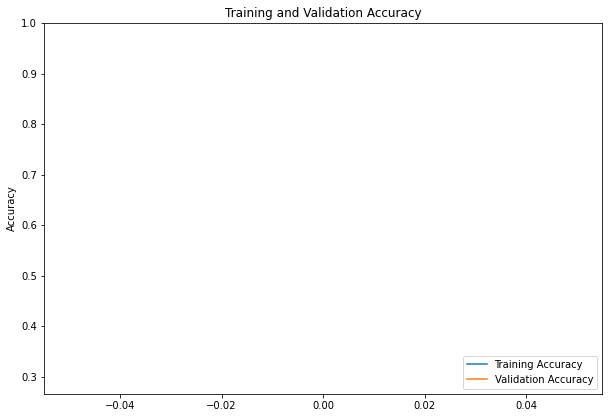

In [36]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

In [37]:
loss0, accuracy0 = model.evaluate(valid_generator)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

93/93 [==============================] - 257s 3s/step - loss: 0.0000e+00 - accuracy: 0.4944
initial loss: 0.00
initial accuracy: 0.49


In [38]:
%tensorboard --logdir /content/log1

UsageError: Line magic function `%tensorboard` not found.


In [41]:
model.save("modelquality.h5")


In [42]:
model.save("/content/gdrive/My Drive/Image Quality/modelquality.h5")
